In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import iisignature
from sklearn.linear_model import  Lasso
from sklearn.metrics import mean_squared_error


In [163]:
# -------------------------------
# 1. Simulate the Heston-type model
# -------------------------------
def simulate_heston(S0, V0, mu, kappa, theta, alpha, rho, T, N):
    """
    Simulate the Heston-type model under measure P:
      dS_t = S_t * mu * dt + S_t * sqrt(V_t) dB_t
      dV_t = kappa (theta - V_t) dt + alpha * sqrt(V_t) dW_t
    with d<B,W> = rho dt.

    Parameters:
      S0    : initial asset price
      V0    : initial variance
      mu    : drift of S (interpreted as the risk-free rate under Q for pricing)
      kappa : mean-reversion rate for V
      theta : long-run variance level
      alpha : volatility of volatility
      rho   : correlation between B and W
      T     : total time horizon
      N     : number of time steps

    Returns:
      S, V  : arrays of simulated S and V (length N+1)
    """
    dt = T / N
    S = np.zeros(N+1)
    V = np.zeros(N+1)
    S[0] = S0
    V[0] = V0

    for i in range(N):
        # simulate independent normals for the Brownian increments:
        dB = np.sqrt(dt) * np.random.randn()
        dZ = np.sqrt(dt) * np.random.randn()
        # impose correlation: dW = rho * dB + sqrt(1-rho^2) * dZ
        dW = rho * dB + np.sqrt(1 - rho**2) * dZ

        # Euler-Maruyama update:
        S[i+1] = S[i] + S[i] * mu * dt + S[i] * np.sqrt(max(V[i], 0)) * dB
        V[i+1] = V[i] + kappa*(theta - V[i]) * dt + alpha * np.sqrt(max(V[i], 0)) * dW

        # Ensure nonnegative variance
        V[i+1] = max(V[i+1], 0)

    return S, V

def Monte_Carlo_Estimation(n_paths, S0, V0, mu, kappa, theta, alpha, rho, T, N):
    prices = np.zeros((n_paths, N+1))
    volatilities = np.zeros((n_paths, N+1))
    for i in range(n_paths):
        S, V = simulate_heston(S0, V0, mu, kappa, theta, alpha, rho, T, N)
        prices[i] = S
        volatilities[i] = V

    return np.mean(prices, axis=0), np.mean(volatilities, axis=0)


#  Set parameters and simulate the path

# Model parameters
S0 = 100.0
V0 = 0.04
mu = 0.05         # risk-free rate for pricing
kappa = 1.5
theta = 0.04
alpha = 0.5
rho = -0.5

# Simulation settings
T = 1.0           # total time (e.g. 1 year)
N = 1065           # number of time steps (use a fine grid for the SDE simulation)
n_paths = 1000 # number of Monte Carlo simulation paths
K = 100.0         # strike price for the European call option

# Compute the average simulated path (for illustration)
S, V = Monte_Carlo_Estimation(n_paths, S0, V0, mu, kappa, theta, alpha, rho, T, N)




In [ ]:
# -------------------------------
# 2.Estimate the “instantaneous” risk‐neutral drivers (B^Q,W^Q)
# -------------------------------

# Observed increments:
dS = np.diff(S)
dV = np.diff(V)

def g(x, y):
    return x * np.sqrt(y)

def h(x, y):
    return alpha * np.sqrt(y)

# For each time step, estimate the instantaneous quadratic variations.
Sigma11 = np.zeros_like(dS)
Sigma22 = np.zeros_like(dV)

for i in range(len(dS)):
    # Using the "end-of-step" values S[i+1], V[i+1].
    Sigma11[i] = np.power(g(S[i+1], V[i+1]),2)
    Sigma22[i] = np.power(h(S[i+1], V[i+1]),2)

# Compute the risk-neutral Brownian path (cumulative sums of increments).
dB_Q = np.zeros_like(dS)
dW_Q = np.zeros_like(dV)

for i in range(len(dS)):
    # To avoid division by zero, we check if the estimated variation is positive.
    if Sigma11[i] > 1e-8:
        dB_Q[i] = dS[i] / np.sqrt(Sigma11[i])
    else:
        dB_Q[i] = 0
    if Sigma22[i] > 1e-8:
        dW_Q[i] = dV[i] / np.sqrt(Sigma22[i])
    else:
        dW_Q[i] = 0

# Reconstruct the risk-neutral Brownian paths by cumulative summation.
B_Q = np.concatenate(([0], np.cumsum(dB_Q)))
W_Q = np.concatenate(([0], np.cumsum(dW_Q)))
# Combine them into a two-dimensional process Y^Q = (t,B^Q, W^Q).
t_scaled=[i/len(W_Q) for i in range(len(W_Q))]
Y_Q = np.column_stack((t_scaled,B_Q, W_Q))  # shape (N+1, 2)

In [ ]:
# -------------------------------
# 3. Compute the signature of Y^Q and perform signature regression
# -------------------------------
m = 2
sig_dim = iisignature.siglength(3, m)  # dimension of signature for a 2D path up to level m

# Build the design matrix X whose row i is the signature of Y^Q over [0, t_i].
X = np.zeros((len(Y_Q), sig_dim))

# For time 0, the signature is the "empty" one (1 followed by zeros).
empty_sig = np.zeros(sig_dim)
empty_sig[0] = 1.0
X[0, :] = empty_sig

for i in range(1, len(Y_Q)):
    path = Y_Q[:i+1]
    X[i, :] = iisignature.sig(path, m)

# Least-squares regression to approximate S.
X_train=X[:len(S)//2,:]
S_train=S[:len(S)//2]
T_train=t_scaled[:len(S)//2]
X_test=X[len(S)//2:,:]
S_test=S[len(S)//2:]
"""ell, residuals, rank, svals = np.linalg.lstsq(X_train, S_train, rcond=None)
S_pred = X.dot(ell)"""
lasso = Lasso(alpha=0.00001)

# Fit the model to the data
lasso.fit(X_train, S_train)

# Get the coefficients
ell = lasso.coef_

# Predict the values
S_pred = lasso.predict(X_train)

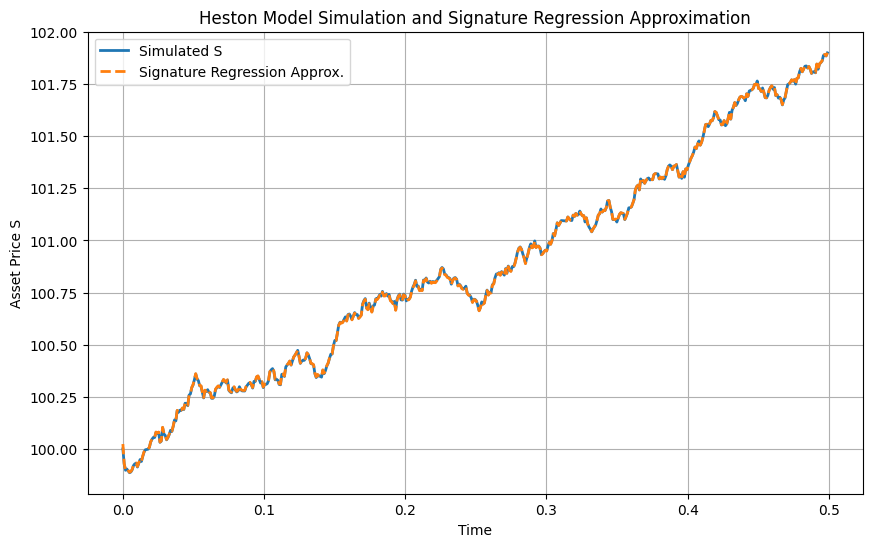

In [167]:
# -------------------------------
# 4. Plot the results
# -------------------------------
plt.figure(figsize=(10, 6))
time_grid = np.linspace(0, T, len(S))  # N+1 points
plt.plot(T_train, S_train, label='Simulated S', lw=2)
plt.plot(T_train, S_pred, label='Signature Regression Approx.', linestyle='--', lw=2)
plt.xlabel('Time')
plt.ylabel('Asset Price S')
plt.title('Heston Model Simulation and Signature Regression Approximation')
plt.legend()
plt.grid(True)
plt.show()


In [168]:
mse_train = mean_squared_error(S_train, S_pred)
test_pred= lasso.predict(X_test)
mse_test = mean_squared_error(S_test,test_pred )


In [169]:
print("mse on train data", mse_train)
print("mse on test data",mse_test)

mse on train data 3.890277811876633e-06
mse on test data 0.00019363214168138996
